In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

##### 讀取數據

In [235]:
df = pd.read_csv('KKboxTrainMemTransac.csv')

In [237]:
# 欲拿掉的特徵值
DropCol = ['age_under26', 'age_level_code', 'payment_method_41']
df = df.drop(columns=DropCol)
# df = df[['msno', 'is_churn', 'bd', 'gender', 'registered_via', 'client_level_code', \
#          'last_last_churn', 'last_auto_renew', 'is_discount', 'amount_per_day', 'longtime_user', \
#          'pay_method_41_ratio']]

In [238]:
df.head()

,msno,is_churn,bd,gender,registered_via,client_level_code,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user,City_1,pay_method_41_ratio
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,36.000,0,9.000,1,1.000,0,2,2.483,0,0.000,0.000
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,38.000,1,9.000,3,0.000,1,23,4.992,1,0.000,0.000
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,27.000,0,9.000,2,0.000,0,10,4.973,0,0.000,0.000
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,23.000,0,9.000,1,1.000,0,3,3.109,0,0.000,0.000
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,27.000,1,9.000,2,0.000,0,9,4.894,1,0.000,0.000


In [242]:
print(df.shape)
df.info(memory_usage='deep')

(775837, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775837 entries, 0 to 775836
Data columns (total 13 columns):
msno                   775837 non-null category
is_churn               775837 non-null int8
bd                     775837 non-null int8
gender                 775837 non-null int8
registered_via         775837 non-null int8
client_level_code      775837 non-null int8
last_last_churn        775837 non-null int8
last_auto_renew        775837 non-null int8
is_discount            775837 non-null int16
amount_per_day         775837 non-null float64
longtime_user          775837 non-null int8
City_1                 775837 non-null int8
pay_method_41_ratio    775837 non-null float64
dtypes: category(1), float64(2), int16(1), int8(9)
memory usage: 85.3 MB


---

##### 優化記憶體&處理不合理值

In [240]:
df = dtype_compressor(df)

In [241]:
df.isnull().sum()

msno                   0
is_churn               0
bd                     0
gender                 0
registered_via         0
client_level_code      0
last_last_churn        0
last_auto_renew        0
is_discount            0
amount_per_day         0
longtime_user          0
City_1                 0
pay_method_41_ratio    0
dtype: int64

In [20]:
# 處理bd缺失值
# df['bd_level_code'] = df['bd_level_code'].fillna(-1)
# 處理city缺失值
# df['city'] = df['city'].fillna('-1')
# 處理gender缺失值
# df['gender'] = df['gender'].fillna(-1)
# 處理registered_via缺失值
# df['registered_via'] = df['registered_via'].fillna(-1)
# 處理age_under26缺失值(依members除去不合理值之年齡平均為29歲，屬於0
# df['age_under26'] = df['age_under26'].fillna(0)
# 處理City-1的缺失值，因為不知道是否為city-1，所以把缺失值分成一類
# df['City_1'] = df['City_1'].fillna(-1)

# 刪除含缺失值的row
# df = df.dropna()

##### 修改型態

In [11]:
'''df_Col = ['is_churn', 'client_level_code', 'last_last_churn', 'last_auto_renew']
for i in df_Col:
    df[i] = df[i].astype('str')'''

"KKboxforRF_Col = ['is_churn', 'client_level_code', 'last_last_churn', 'last_auto_renew']\nfor i in KKboxforRF_Col:\n    KKboxforRF[i] = KKboxforRF[i].astype('str')"

##### 特徵縮放

In [16]:
# df['is_discount'] = df['is_discount'] / df['is_discount'].max()
# df['age'] = df['age'] / df['age'].max()

---

##### 確認各特徵關聯性

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


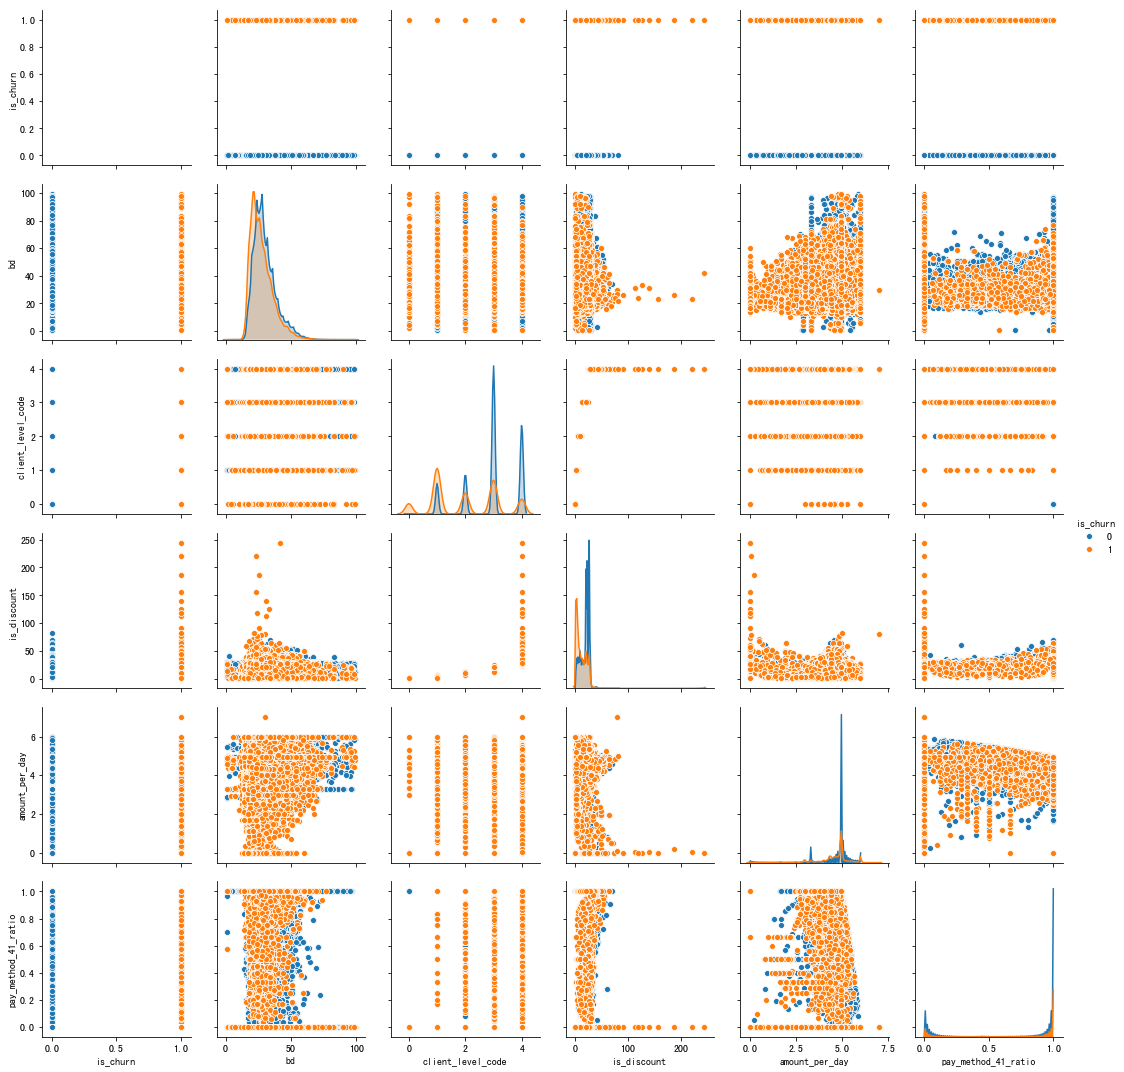

In [234]:
sns.pairplot(hue='is_churn', data=df.iloc[:, [1,2,5,8,9,11]])
plt.show()

---

### RandomForestClassifier

##### 拆分訓練集與測試集

In [243]:
from sklearn.model_selection import train_test_split

In [244]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

In [245]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=87)

In [246]:
'''from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)'''

'from sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.transform(X_test)'

---

##### 建立隨機森林分類模型

In [247]:
from sklearn.ensemble import RandomForestClassifier

##### 使用SMOTE處理數據不平衡問題

In [248]:
from imblearn.over_sampling import SMOTE
over_samples = SMOTE(random_state=87)
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train) 

In [249]:
print(y_train.value_counts()/len(y_train)) 
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0   0.889
1   0.111
Name: is_churn, dtype: float64
1   0.500
0   0.500
dtype: float64


##### 建立隨機森林分類模型

In [250]:
RfClassifier = RandomForestClassifier(random_state=87, n_estimators=100, criterion='gini', max_depth=30, min_samples_split=8, max_features='sqrt')

##### 訓練

In [251]:
RfClassifier.fit(over_samples_X,over_samples_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=87, verbose=0, warm_start=False)

In [252]:
RfClassifier.score(X=over_samples_X, y=over_samples_y)

0.9292833201178422

##### 預測

In [253]:
y_pred= RfClassifier.predict(np.array(X_test))

##### 確認

In [254]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93    207082
           1       0.45      0.57      0.50     25670

   micro avg       0.88      0.88      0.88    232752
   macro avg       0.70      0.74      0.72    232752
weighted avg       0.89      0.88      0.88    232752



##### classification report結果解讀：
* 正樣本精確率：45%， 召回率：58%， f1-score：50%
* 負樣本精確率：95%， 召回率：91%， f1-score：93%

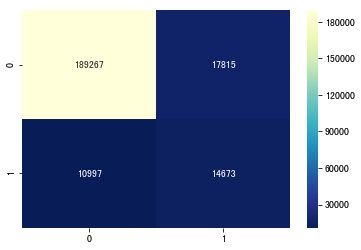

In [255]:
cm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt="d")

##### confusion matrix結果解讀：

In [256]:
# 根據cm填入值
TP = 14786
FN = 10884
TN = 188806
FP = 18276
print('正樣本準確率(Precision)={:.1f}%'.format(100*TP/(TP+FP)))
print('正樣本召回率(Recall，避免假陰性)={:.1f}%'.format(100*TP/(TP+FN)))
print('正樣本特異度(Sensitivity，避免假陽性)={:.1f}%'.format(100*TN/(FP+TN)))

正樣本準確率(Precision)=44.7%
正樣本召回率(Recall，避免假陰性)=57.6%
正樣本特異度(Sensitivity，避免假陽性)=91.2%


In [257]:
auc_RfClassifier = roc_auc_score(y_test, y_pred)

In [258]:
print('AUC: %.3f' % auc_RfClassifier)

AUC: 0.743


In [259]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

##### 繪製ROC

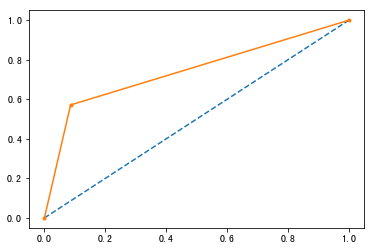

In [260]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

Variable: amount_per_day       Importance: 0.26
Variable: last_auto_renew      Importance: 0.19
Variable: is_discount          Importance: 0.19
Variable: bd                   Importance: 0.12
Variable: client_level_code    Importance: 0.05
Variable: pay_method_41_ratio  Importance: 0.05
Variable: gender               Importance: 0.04
Variable: last_last_churn      Importance: 0.03
Variable: longtime_user        Importance: 0.03
Variable: registered_via       Importance: 0.02
Variable: City_1               Importance: 0.01


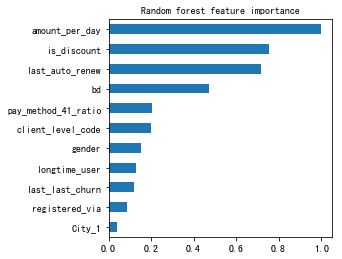

In [261]:
feature_list = list(X_train.columns)

# Get numerical feature importances
importances = list(RfClassifier.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(X_train, round(importance, 2)) for X_train, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# 畫barplot
fi = pd.concat([pd.DataFrame(df.columns[2:], columns = ['feature']), pd.DataFrame({'fscore':RfClassifier.feature_importances_})], axis=1, sort=False)
fi['fscore'] = fi['fscore'] / fi['fscore'].max()
fi.sort_values('fscore', ascending = True, inplace = True)
fi.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(4, 4))
plt.title('Random forest feature importance', fontsize = 10)
plt.xlabel('')
plt.ylabel('')
plt.show()

---

### 確認特徵間關係

##### 每日平均花費(amount_per_day) vs 獲得折扣次數(is_discount)

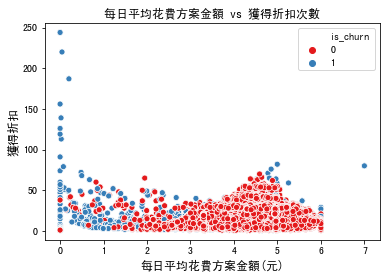

In [271]:
sns.scatterplot(x=df['amount_per_day'], y=df['is_discount'], hue=df['is_churn'], palette='Set1')
plt.ylabel('獲得折扣', fontsize=12)
plt.xlabel('每日平均花費方案金額(元)', fontsize=12)
plt.title("每日平均花費方案金額 vs 獲得折扣次數", fontsize=12)
plt.show()

##### 每日平均花費(amount_per_day) vs 上次自動續約(last_auoto_renew)

<Figure size 432x216 with 0 Axes>

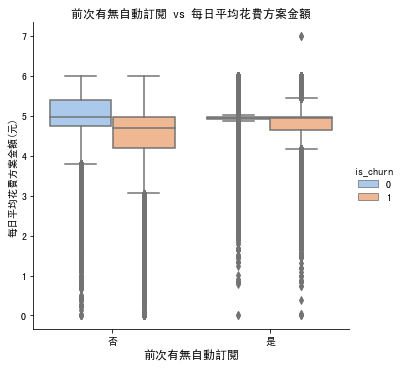

In [270]:
plt.figure(figsize=(6,3))
sns.catplot(x='last_auto_renew', y='amount_per_day', hue='is_churn', kind="box", data=df, palette='pastel')
plt.xlabel('前次有無自動訂閱', fontsize=12)
plt.ylabel('每日平均花費方案金額(元)')
plt.xticks(np.arange(2), ('否', '是'))
plt.title("前次有無自動訂閱 vs 每日平均花費方案金額", fontsize=12)
plt.show()

##### 每日平均花費(amount_per_day) vs 年齡(bd)

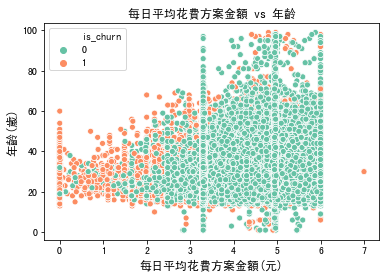

In [269]:
sns.scatterplot(x=df['amount_per_day'], y=df['bd'], hue=df['is_churn'], palette='Set2')
plt.title("每日平均花費方案金額 vs 年齡", fontsize=12)
plt.xlabel('每日平均花費方案金額(元)', fontsize=12)
plt.ylabel('年齡(歲)', fontsize=12)
plt.show()

##### 每日平均花費(amount_per_day) vs 交易次數(client_level_code)

* 新使用者數量稀少，暫不參考；交易次數12~24次的流失/非流失不受到用戶每日平均花費影響

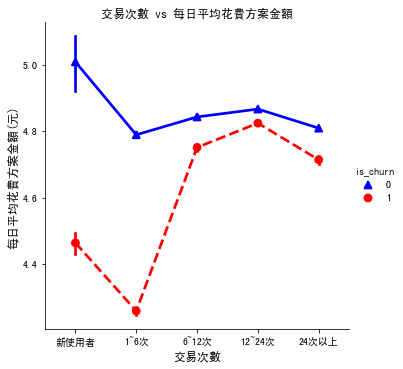

In [273]:
sns.catplot(x='client_level_code', y='amount_per_day', hue='is_churn', kind="point", data=df, linestyles=["-", "--"], markers=["^", "o"], palette={0: "b", 1: "r"})
plt.xlabel('交易次數', fontsize=12)
plt.ylabel('每日平均花費方案金額(元)', fontsize=12)
plt.xticks(np.arange(5), ('新使用者','1~6次', '6~12次', '12~24次', '24次以上'))
plt.title("交易次數 vs 每日平均花費方案金額", fontsize=12)
plt.show()

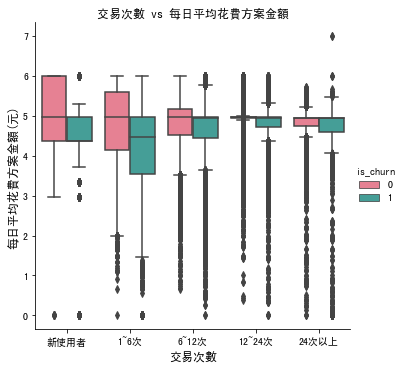

In [274]:
sns.catplot(x='client_level_code', y='amount_per_day', hue='is_churn', kind="box", data=df, palette='husl')
plt.title("交易次數 vs 每日平均花費方案金額", fontsize=12)
plt.xlabel('交易次數', fontsize=12)
plt.ylabel('每日平均花費方案金額(元)', fontsize=12)
plt.xticks(np.arange(5), ('新使用者','1~6次', '6~12次', '12~24次', '24次以上'))
plt.show()

##### 每日平均花費(amount_per_day) vs 使用編號41付款方式(pay_method_41_ratio)

* 使用編號41付款方式概率與流失傾向無太大關聯性，可能要與其他特徵進行比較確認。

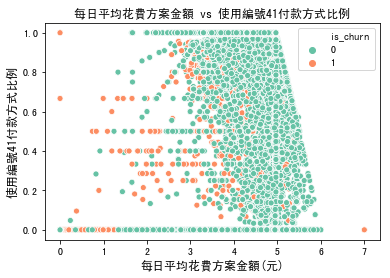

In [275]:
sns.scatterplot(x=df['amount_per_day'], y=df['pay_method_41_ratio'], hue=df['is_churn'], palette='Set2')
plt.title("每日平均花費方案金額 vs 使用編號41付款方式比例", fontsize=12)
plt.ylabel('使用編號41付款方式比例', fontsize=12)
plt.xlabel('每日平均花費方案金額(元)', fontsize=12)
plt.show()

##### 每日平均花費(amount_per_day) vs gender(性別)

* 性別方面，男女性流失/非流失沒有太大差別；**缺失值分類(可能為用戶不填性別)且每日平均花費3~5元**較具流失傾向。

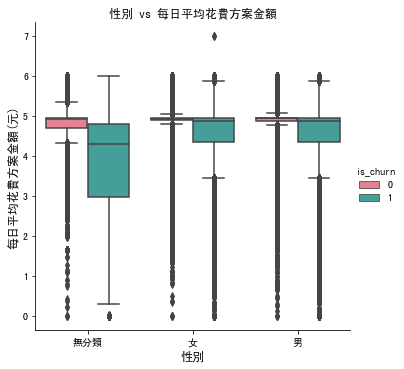

In [276]:
sns.catplot(x='gender', y='amount_per_day', hue='is_churn', kind="box", data=df, palette='husl')
plt.title("性別 vs 每日平均花費方案金額", fontsize=12)
plt.xlabel('性別', fontsize=12)
plt.ylabel('每日平均花費方案金額(元)', fontsize=12)
plt.xticks(np.arange(3), ('無分類', '女', '男'))
plt.show()

##### 每日平均花費(amount_per_day) vs 連續/非連續訂閱(last_last_churn)

* 不管連續/非連續訂閱，流失概率相當，但非連續訂閱者不流失較少

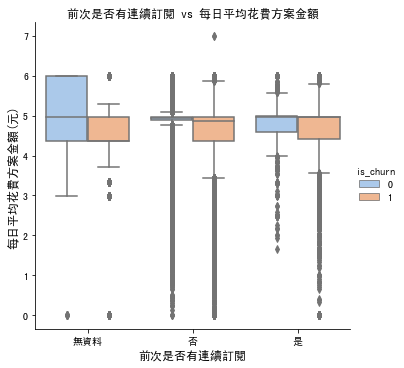

In [277]:
sns.catplot(x='last_last_churn', y='amount_per_day', hue='is_churn', kind="box", data=df, palette='pastel')
plt.title("前次是否有連續訂閱 vs 每日平均花費方案金額", fontsize=12)
plt.xlabel('前次是否有連續訂閱', fontsize=12)
plt.ylabel('每日平均花費方案金額(元)', fontsize=12)
plt.xticks(np.arange(3), ('無資料', '否', '是'))
plt.show()

---

### 確認單特徵視覺化

##### 上次自動續約(last_auto_renew)

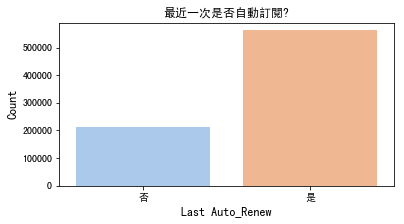

In [286]:
plt.figure(figsize=(6,3))
sns.countplot(x="last_auto_renew", data=df, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Last Auto_Renew', fontsize=12)
plt.xticks(np.arange(2), ('否', '是'))
plt.title("最近一次是否自動訂閱?", fontsize=12)
plt.show()

##### 用戶交易次數client_level_code

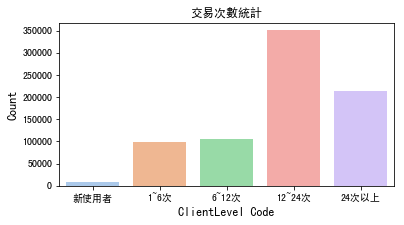

In [280]:
plt.figure(figsize=(6,3))
sns.countplot(x="client_level_code", data=df, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('ClientLevel Code', fontsize=12)
plt.xticks(np.arange(5), ('新使用者','1~6次', '6~12次', '12~24次', '24次以上'))
plt.title("交易次數統計", fontsize=12)
plt.show()

##### 性別(gender)

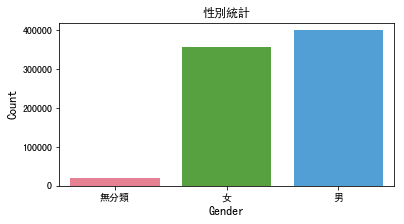

In [287]:
plt.figure(figsize=(6,3))
sns.countplot(x="gender", data=df, palette = "husl")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(np.arange(3), ('無分類','女', '男'))
plt.title("性別統計", fontsize=12)
plt.show()

##### 上次交易是否連續訂閱(last_last_churn)

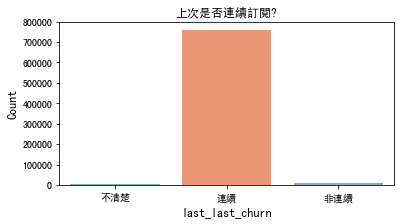

In [282]:
plt.figure(figsize=(6,3))
sns.countplot(x="last_last_churn", data=df, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('last_last_churn', fontsize=12)
plt.xticks(np.arange(3), ('不清楚','連續', '非連續'))
plt.title("上次是否連續訂閱?", fontsize=12)
plt.show()

##### 長期用戶(定義訂閱時間大於一年者)(longtime_user)

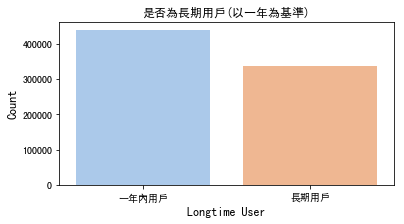

In [283]:
plt.figure(figsize=(6,3))
sns.countplot(x="longtime_user", data=df, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Longtime User', fontsize=12)
plt.xticks(np.arange(2), ('一年內用戶','長期用戶'))
plt.title("是否為長期用戶(以一年為基準)", fontsize=12)
plt.show()

##### 年齡分布(bd)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


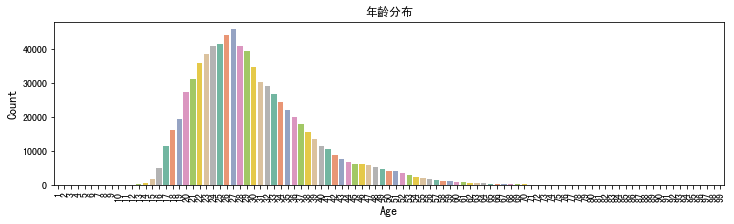

In [289]:
tmp_bd = df[(df.bd != "NaN") & (df.bd != -1)]
plt.figure(figsize=(12,3))
bd_order_2 = tmp_bd['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=tmp_bd , order = bd_order_2, palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("年齡分布", fontsize=12)
plt.show()

##### 登入使用裝置(Registered_via)

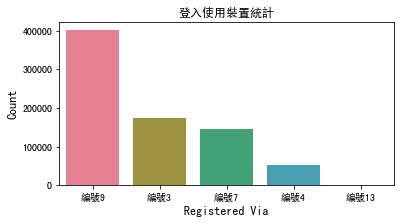

In [294]:
plt.figure(figsize=(6,3))
R_V_order = df['registered_via'].unique()
sns.countplot(x="registered_via", data=df, order=df["registered_via"].value_counts().index, palette = "husl")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(np.arange(5), ('編號9', '編號3', '編號7', '編號4', '編號13'))
plt.title("登入使用裝置統計", fontsize=12)
plt.show()

---

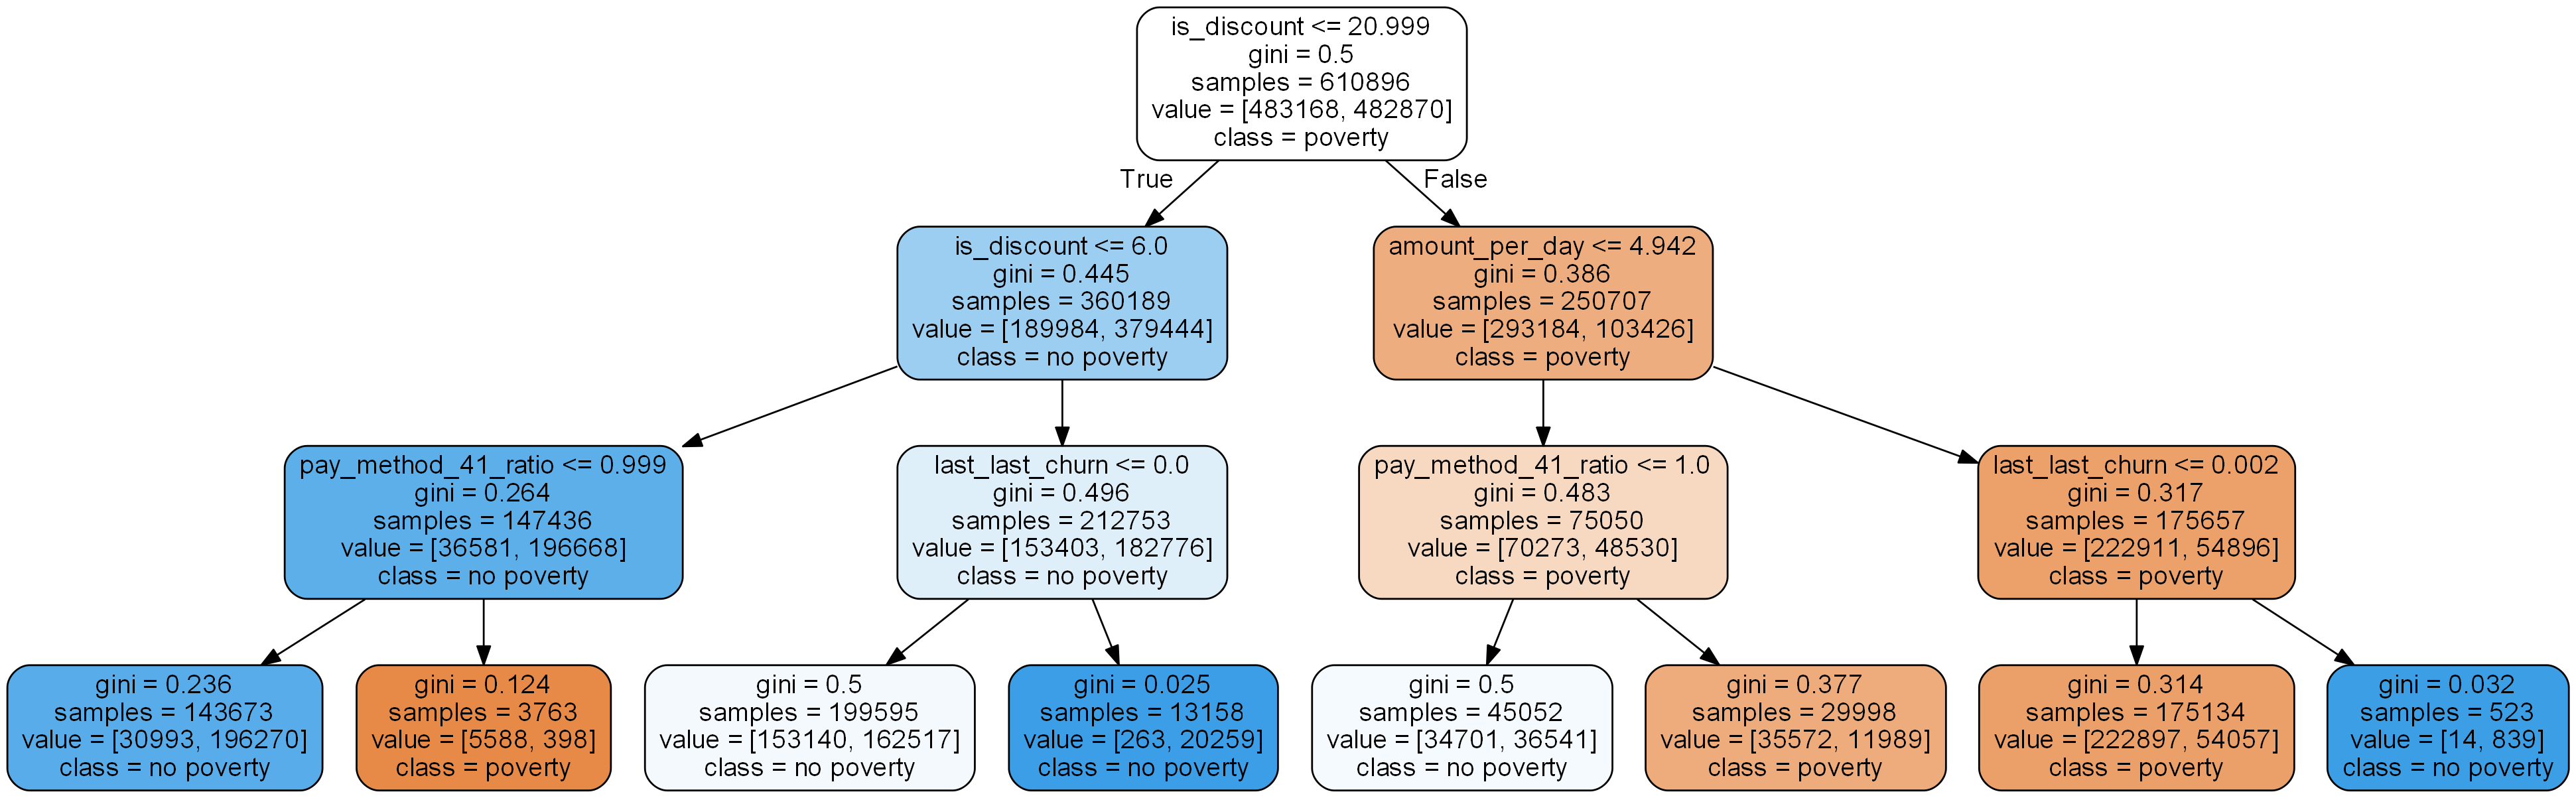

In [67]:
estimator = RfClassifier.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=X_train.columns, max_depth = 3, 
                class_names = ['poverty', 'no poverty'], filled = True)

call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

---

## RandomForestRegressor(參考就好)

##### 資料集使用SMOTE處理數據不平衡後

##### 訓練

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
rf_regressor = RandomForestRegressor(n_estimators=10, max_depth=30, min_samples_split=8, random_state=87)

In [63]:
rf_regressor.fit(over_samples_X,over_samples_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=87, verbose=0, warm_start=False)

In [64]:
rf_regressor.score(X=over_samples_X, y=over_samples_y)

0.772777596057566

##### 預測

In [66]:
rf_regressor_pred = rf_regressor.predict(X_test)

##### 確認

In [67]:
auc_rf_regressor = roc_auc_score(y_test, rf_regressor_pred)

In [68]:
print('AUC: %.3f' % auc_rf_regressor)

AUC: 0.816


In [72]:
fpr_rf_regressor, tpr_rf_regressor, thresholds_rf_regressor = roc_curve(y_test, rf_regressor_pred)

##### 繪製ROC

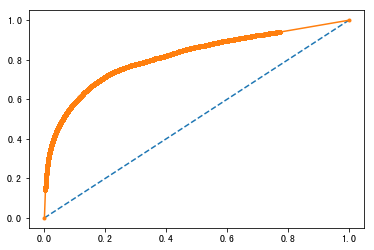

In [73]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_rf_regressor, tpr_rf_regressor, marker='.')
plt.show()

##### 特徵重要性

In [74]:
feature_list = list(X_train.columns)

# Get numerical feature importances
importances = list(rf_regressor.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(X_train, round(importance, 2)) for X_train, importance in zip(feature_list[1:], importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: is_discount          Importance: 0.31
Variable: longtime_user        Importance: 0.27
Variable: amount_per_day       Importance: 0.15
Variable: gender               Importance: 0.11
Variable: registered_via       Importance: 0.04
Variable: pay_method_41_ratio  Importance: 0.03
Variable: client_level_code    Importance: 0.02
Variable: last_auto_renew      Importance: 0.02
Variable: last_last_churn      Importance: 0.0


---

### 測試最佳模型參數

##### 確認袋外分數(模型泛化能力)以及AUC分數

In [20]:
rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(over_samples_X,over_samples_y)
print(rf0.oob_score_)
y_predprob = rf0.predict_proba(over_samples_X)[:,1]
print("AUC Score (Train): %f" % roc_auc_score(over_samples_y,y_predprob))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.8783308731126519
AUC Score (Train): 0.984015


##### 對於n_estimator做最佳參數搜索

In [21]:
param_test1= {'n_estimators':[10, 50, 100, 200]}
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=2,
                                 max_depth=5, max_features='sqrt', random_state=87),
                       param_grid =param_test1, scoring='roc_auc',cv=2)
gsearch1.fit(over_samples_X,over_samples_y)
gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['params'], gsearch1.best_params_, gsearch1.best_score_

(array([0.85366233, 0.85575398, 0.85666811, 0.85691022]),
 [{'n_estimators': 10},
  {'n_estimators': 50},
  {'n_estimators': 100},
  {'n_estimators': 200}],
 {'n_estimators': 200},
 0.8569102170573542)

* 對於n_estimator測試的4個參數，結果差異不大，因此選擇10

##### 對max_depth與min_samples_split做最佳參數搜索

In [22]:
param_test2= {'max_depth':[10, 30, 50, 100], 'min_samples_split':[2, 4, 8, 10]}
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 10,
                                 max_features='sqrt', oob_score=True, random_state=87),
                       param_grid = param_test2,scoring='roc_auc',iid=False, cv=2)
gsearch2.fit(over_samples_X,over_samples_y)
gsearch2.cv_results_['mean_test_score'], gsearch2.best_params_, gsearch2.best_score_

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means t

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means t

(array([0.89013853, 0.88946998, 0.8896754 , 0.89008437, 0.9406351 ,
        0.94239983, 0.94267312, 0.94264954, 0.93832712, 0.94153823,
        0.94251557, 0.94225188, 0.93833585, 0.94153823, 0.94251557,
        0.94225188]),
 {'max_depth': 30, 'min_samples_split': 8},
 0.9426731230544922)

* 依照測試，尋找較佳之max_depth=30，min_samples_split=8